In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from copy import deepcopy

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import sys
sys.path.insert(0,'..')

from vf_portalytics.feature_subset import FeatureSubsetModel, FeatureSubsetTransform
from vf_portalytics.model import PredictionModel

/home/ctselas/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Not necessary when vf-portalytics is imported as a library


In [3]:
def make_dataset(random_state, n_informative, **kwargs):
    x, y = make_regression(
        
        n_samples=1000, 
        n_features=5,
        noise=0 if random_state == 1 else 10,
        bias=10 if random_state == 1 else 1000,
        n_informative=min(n_informative, 5), 
        random_state=random_state
    )
    x = pd.DataFrame(x)
    x.columns = ['feature_{}'.format(n) for n in x.columns]
    x = x.assign(**kwargs)
    
    return x, pd.Series(y)

## Generate two sets of artificial regression data with different characteristics

In [4]:
x1, y1 = make_dataset(1, 5, account_banner='A', product_desc='X')
x2, y2 = make_dataset(2, 3, account_banner='B', product_desc='Y')

# combine into one dataset
total_x = pd.concat([x1, x2], axis=0, ignore_index=True).reset_index(drop=True)
total_y = pd.concat([y1, y2], axis=0, ignore_index=True).reset_index(drop=True)

# Split into train and test
train_index, test_index = train_test_split(total_x.index, random_state=5)
train_x, train_y = total_x.loc[train_index, :], total_y.loc[train_index]
test_x, test_y = total_x.loc[test_index, :], total_y.loc[test_index]

# Create VF Model Wrapper

In [5]:
# Note: must use one_hot_encode=False to prevent one-hot encoding of categorical features in input data
model_wrapper = PredictionModel("my_test_model", path='/tmp', one_hot_encode=False)

# Generate PolyNomial Features for Feature Subsets 

In [6]:
# Create a pipeline and perform cross validation using both meth
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


subset_cols = ('account_banner', 'product_desc')
sub_models = {
    ('A', 'X'): LinearRegression(),
    ('B', 'Y'): DecisionTreeRegressor(),
}


pipeline = Pipeline([  
  ('transform', FeatureSubsetTransform(group_cols=subset_cols, transformer=PolynomialFeatures(2))),
  ('estimate', FeatureSubsetModel(group_cols=subset_cols, sub_models=sub_models))
])


## Train the Model using the Train Split

In [7]:
model_wrapper.model = pipeline
model_wrapper.features = {
    # Grouping features
    'account_banner': [],
    'product_desc': [],
    # other feaures
    'feature_0': [],
    'feature_1': [],
    'feature_2': [],
    'feature_3': [],
    'feature_4': [],
}

model_wrapper.target = {'target': []}
model_wrapper.ordered_column_list = sorted(model_wrapper.features.keys())
model_wrapper.model.fit(train_x, train_y)

Pipeline(memory=None,
         steps=[('transform',
                 FeatureSubsetTransform(group_cols=('account_banner',
                                                    'product_desc'),
                                        transformer=PolynomialFeatures(degree=2,
                                                                       include_bias=True,
                                                                       interaction_only=False,
                                                                       order='C'))),
                ('estimate',
                 FeatureSubsetModel(group_cols=('account_banner',
                                                'product_desc'),
                                    sub_models={('A', 'X'): LinearRegression(copy_X=True,
                                                                             fit_intercept=True,
                                                                             n_jobs=None,
                     

## Make Predictions and Compare Against Test Split

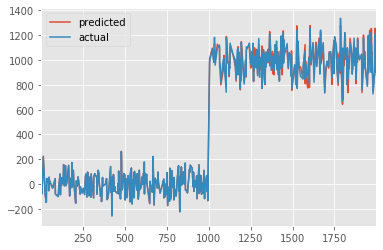

In [8]:
predicted_y = model_wrapper.model.predict(test_x)
output = pd.DataFrame({'predicted': predicted_y, 'actual': test_y})

_ = output.plot()

# Re-train with all Data and Save the Model

In [9]:
model_wrapper.model = pipeline
_ = model_wrapper.model.fit(total_x, total_y)

model_wrapper.save()

# Load Pre-Saved Model 

In [10]:
# Don't specify one_hot_encode here because it will be looked up from the pickle file
saved_model = PredictionModel('my_test_model', path='/tmp')
saved_model.model

Pipeline(memory=None,
         steps=[('transform',
                 FeatureSubsetTransform(group_cols=('account_banner',
                                                    'product_desc'),
                                        transformer=PolynomialFeatures(degree=2,
                                                                       include_bias=True,
                                                                       interaction_only=False,
                                                                       order='C'))),
                ('estimate',
                 FeatureSubsetModel(group_cols=('account_banner',
                                                'product_desc'),
                                    sub_models={('A', 'X'): LinearRegression(copy_X=True,
                                                                             fit_intercept=True,
                                                                             n_jobs=None,
                     

In [11]:
saved_model.features

{'account_banner': [],
 'product_desc': [],
 'feature_0': [],
 'feature_1': [],
 'feature_2': [],
 'feature_3': [],
 'feature_4': []}

## Predict using Saved Model

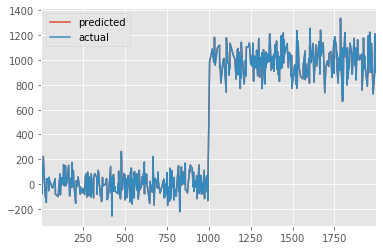

In [12]:
predicted_y = saved_model.model.predict(test_x)
output = pd.DataFrame({'predicted': predicted_y, 'actual': test_y})
_ = output.plot()